<a href="https://colab.research.google.com/github/svperbeast/ai_lab/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project

## FCFS(First Come First Served) Job Scheduling

In [1]:
class Process:
  def __init__(self, user, sw_type, requested_n_cores, submit_time, burst_time):
    self.user = user
    self.sw_type = sw_type
    self.requested_n_cores = requested_n_cores
    self.submit_time = submit_time
    self.burst_time = burst_time
    self.start_time = 0
    self.end_time = 0
    self.wait_time = 0
    self.used_cores = []

  def __str__(self):
    s = ('Process user {} sw_type {} requested_n_cores {}({}) submit_time {} ' +
         'burst_time {} start_time {} end_time {} wait_time {}')
    return s.format(self.user, self.sw_type, self.requested_n_cores,
                    self.used_cores, self.submit_time, self.burst_time,
                    self.start_time, self.end_time, self.wait_time)

In [2]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

class FCFS:
  def __init__(self, n_cores,
               start_time_offset=0, figsize=None, color_map=None):
    self.n_cores = n_cores
    self.start_time_offset = start_time_offset
    self.figsize = figsize
    self.color_map = color_map

  def _get_total_wait_time(self, procs):
    total_wait_time = 0
    for proc in procs:
      total_wait_time += proc.wait_time
    
    return total_wait_time
  
  def _get_gantt_plot(self, procs):
    ytick = 5
    
    fig, gnt = plt.subplots(figsize=self.figsize)

    gnt.set_ylim(0, (self.n_cores + 1) * ytick)
    gnt.set_xlabel('time')
    gnt.set_ylabel('cores')

    gnt.set_yticks(list(range(ytick, (self.n_cores * ytick) + ytick, ytick)))
    gnt.set_yticklabels(list(map(str, list(range(1, self.n_cores + 1)))))

    from tqdm import tqdm
    for i in tqdm(range(len(procs)), position=0, leave=True):
      proc = procs[i]
      start_time = proc.start_time
      duration = proc.burst_time

      for core in proc.used_cores:
        y = ((core + 1) * ytick) - 2
        w = 3
        color = None
        if self.color_map and (proc.user, proc.sw_type) in self.color_map:
          color = self.color_map[(proc.user, proc.sw_type)]
        gnt.broken_barh([(start_time, duration)], (y, w),
                        facecolors=color)

    canvas = FigureCanvas(fig)
    canvas.draw()
    image = canvas.buffer_rgba()
    return np.asarray(image)

  def run(self, input_procs, get_plot=False):
    """
    returns handled process list, total wait_time and gantt plot (numpy array).
    """
    if len(input_procs) == 0:
      raise Exception('the number of input_procs is 0.')

    procs = copy.copy(input_procs)
    handled_procs = []

    core_status = [0] * self.n_cores
    cur_time = 0
    
    # handle the first process
    proc = procs[0]
    n_cores = proc.requested_n_cores
    if n_cores > self.n_cores:
      ncores = self.n_cores

    proc.end_time = proc.burst_time
    proc.start_time = cur_time
    proc.wait_time = (proc.start_time - 
                      (proc.submit_time - self.start_time_offset))

    used_cores = []
    for i in range(len(core_status)):
      if n_cores == 0:
        break

      if core_status[i] <= cur_time:
        core_status[i] = cur_time + proc.burst_time
        used_cores.append(i)
        n_cores -= 1

    proc.used_cores = used_cores

    procs.remove(proc)
    handled_procs.append(proc)

    # handle the rest of the procsesses
    while len(procs) > 0:
      proc = procs[0]

      # adjust cur_time regarding proc.submit_time
      if cur_time < proc.submit_time:
        cur_time = proc.submit_time

      n_cores = proc.requested_n_cores
      if n_cores > self.n_cores:
        ncores = self.n_cores
      
      avail_cores = []
      for i in range(len(core_status)):
        if core_status[i] <= cur_time:
          avail_cores.append(i)
      
      if n_cores <= len(avail_cores):
        used_cores = []
        for ci in avail_cores:
          if n_cores == 0:
            break

          core_status[ci] = cur_time + proc.burst_time
          used_cores.append(ci)
          n_cores -= 1

        proc.end_time = cur_time + proc.burst_time
        proc.start_time = cur_time
        proc.wait_time = (proc.start_time - 
                          (proc.submit_time - self.start_time_offset))
        proc.used_cores = used_cores

        procs.remove(proc)
        handled_procs.append(proc)
      else:
        # update cur_time when #cores are satisfied..
        ts = set(core_status)
        ts = sorted(ts)
        ts = [t for t in ts if (cur_time + 1) < t]
        found = False

        for t in ts:
          t += 1
          avail_cores = []
          for i in range(len(core_status)):
            if core_status[i] < t:
              avail_cores.append(i)
          
          if n_cores <= len(avail_cores):
            found = True
            break

        if found:
          cur_time = t
        else:
          raise Exception('can not update cur_time.')

    total_wait_time = self._get_total_wait_time(handled_procs)
    image = None
    if get_plot:
      image = self._get_gantt_plot(handled_procs)

    return handled_procs, total_wait_time, image

In [9]:
users = ['user1', 'user2', 'user3']
jobs = [1, 2, 3]

job_color_map = {}
n_colors = len(users) * len(jobs)

def get_cmap(n, name='hsv'):
  return plt.cm.get_cmap(name, n)

cmap = get_cmap(n_colors)
cmap_index = 0

for i in range(len(users)):
  for j in range(len(jobs)):
    key = (users[i], jobs[j])
    if key not in job_color_map:
      job_color_map[key] = cmap(cmap_index)
      cmap_index += 1

print(job_color_map)

{('user1', 1): (1.0, 0.0, 0.0, 1.0), ('user1', 2): (1.0, 0.7382819882819882, 0.0, 1.0), ('user1', 3): (0.5234360234360234, 1.0, 0.0, 1.0), ('user2', 1): (0.0, 1.0, 0.21484500507147306, 1.0), ('user2', 2): (0.0, 1.0, 0.9531223422015865, 1.0), ('user2', 3): (0.0, 0.30859596484596485, 1.0, 1.0), ('user3', 1): (0.4296860234360234, 0.0, 1.0, 1.0), ('user3', 2): (1.0, 0.0, 0.8320319882819882, 1.0), ('user3', 3): (1.0, 0.0, 0.09375, 1.0)}


100%|██████████| 3/3 [00:00<00:00, 49.40it/s]


Process user user1 sw_type 2 requested_n_cores 1([0]) submit_time 0 burst_time 100 start_time 0 end_time 100 wait_time 0
Process user user2 sw_type 1 requested_n_cores 1([1]) submit_time 0 burst_time 100 start_time 0 end_time 100 wait_time 0
Process user user3 sw_type 3 requested_n_cores 8([0, 1, 2, 3, 4, 5, 6, 7]) submit_time 1 burst_time 400 start_time 101 end_time 501 wait_time 100
total wait time: 100
(288, 432, 4)


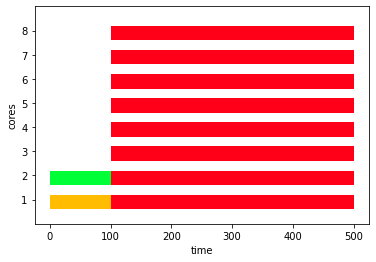

In [11]:
sched = FCFS(8, color_map=job_color_map)
procs = []
procs.append(Process('user1', 2, 1, 0, 100))
procs.append(Process('user2', 1, 1, 0, 100))
procs.append(Process('user3', 3, 8, 1, 400))

procs, tot_wt, image = sched.run(procs, get_plot=True)
for p in procs:
  print(p)
print('total wait time: {}'.format(tot_wt))
print(image.shape)

## Sample data

In [ ]:
import pandas as pd

df = pd.read_csv('/content/job_20201029.csv')
df

,JobID,UserID,SubmitTime,RunTime,CPUNum,Queue
0,1,kangseok.moon,3082,29376,8,fluent
1,2,jw.yu,5679,26745,32,fluent
2,3,giyeob.yang,25633,610,1,cfx
3,4,giyeob.yang,25633,720,32,cfx
4,5,minsock.kim,26555,7052,1,cfx
...,...,...,...,...,...,...
382,383,jongjin.bae,83871,13151,128,fluent
383,384,daeseong.woo,84534,1826,128,fluent
384,385,byeonghun.kim,84886,1588,128,fluent
385,386,yh89.lee,84915,914,128,fluent


In [ ]:
import matplotlib.pyplot as plt

job_color_map = {}
n_colors = len(df['UserID'].unique()) * len(df['Queue'].unique())

def get_cmap(n, name='hsv'):
  return plt.cm.get_cmap(name, n)

cmap = get_cmap(n_colors)
cmap_index = 0

for i, row in df.iterrows():
  key = (row['UserID'], row['Queue'])
  if key not in job_color_map:
    job_color_map[key] = cmap(cmap_index)
    cmap_index += 1


100%|██████████| 15/15 [00:00<00:00, 26.64it/s]


Process user kangseok.moon sw_type fluent requested_n_cores 8([0, 1, 2, 3, 4, 5, 6, 7]) submit_time 3082 burst_time 29376 start_time 0 end_time 29376 wait_time 0
Process user jw.yu sw_type fluent requested_n_cores 32([8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]) submit_time 5679 burst_time 26745 start_time 5679 end_time 32424 wait_time 3082
Process user giyeob.yang sw_type cfx requested_n_cores 1([40]) submit_time 25633 burst_time 610 start_time 25633 end_time 26243 wait_time 3082
Process user giyeob.yang sw_type cfx requested_n_cores 32([41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]) submit_time 25633 burst_time 720 start_time 25633 end_time 26353 wait_time 3082
Process user minsock.kim sw_type cfx requested_n_cores 1([40]) submit_time 26555 burst_time 7052 start_time 26555 end_time 33607 wait_time 3082
Process user suil.pa

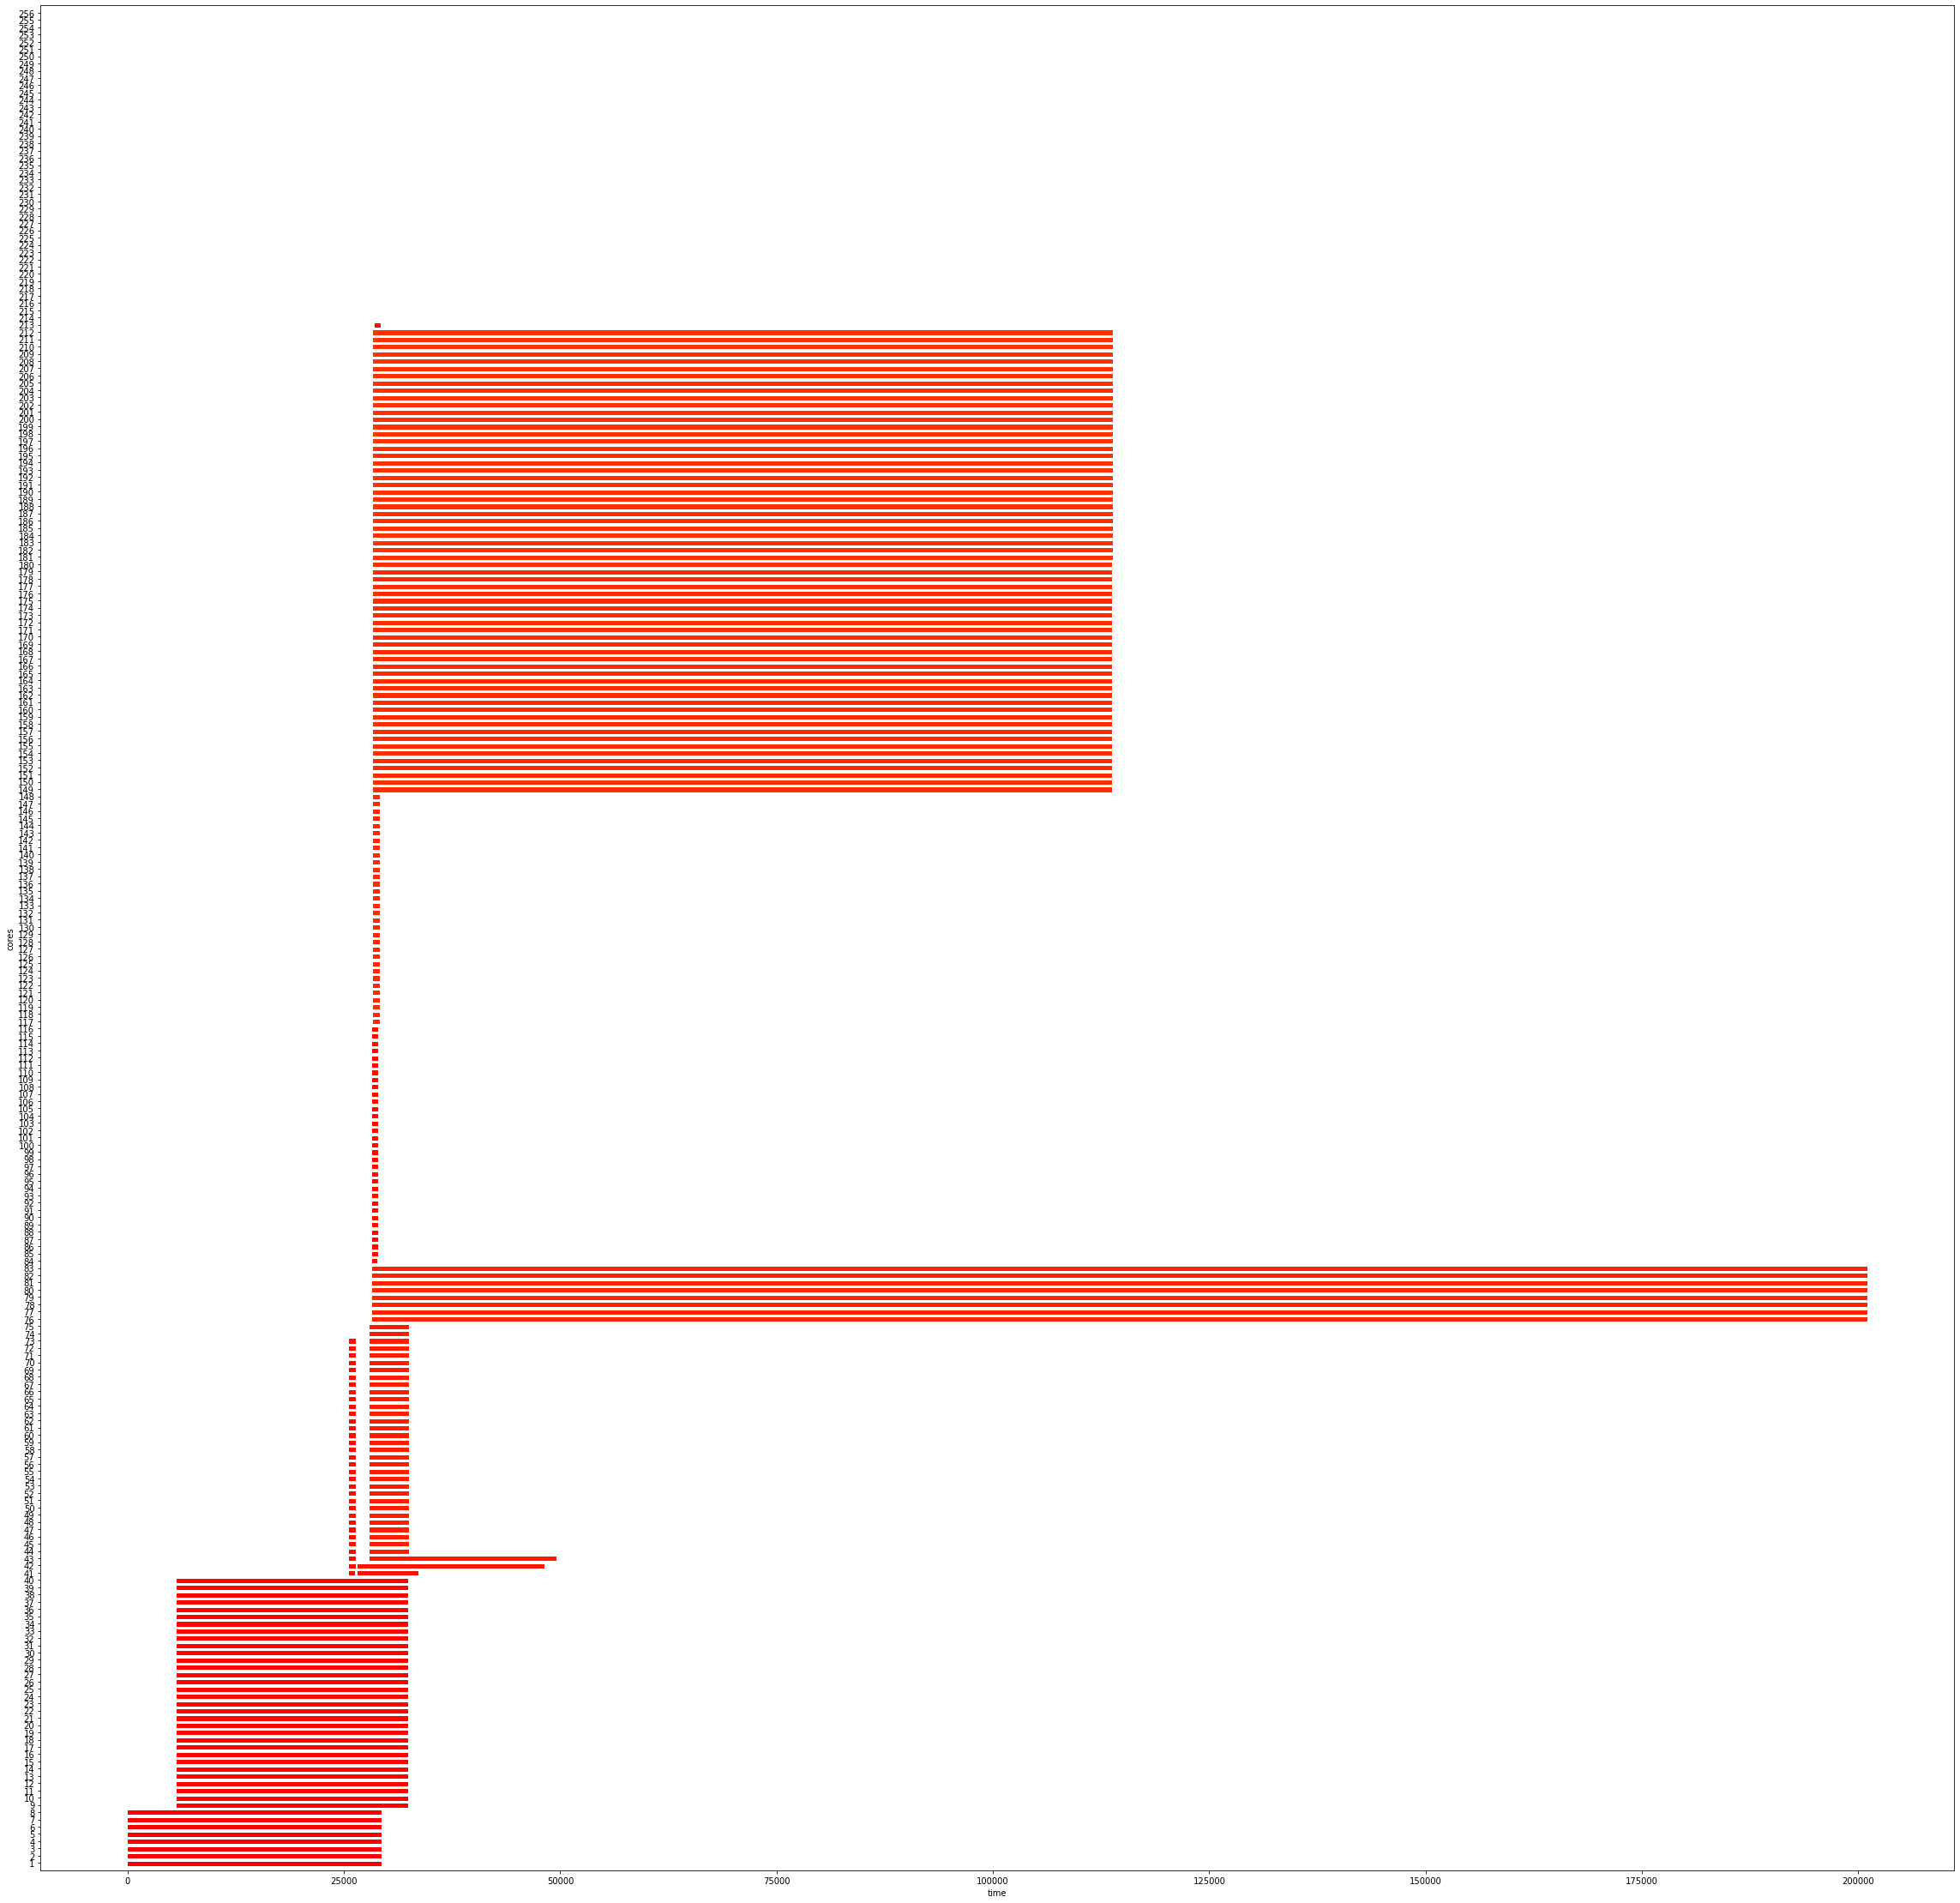

In [ ]:
procs = []

for i, row in df.iterrows():
  user = row['UserID']
  sw_type = row['Queue']
  requested_n_cores = row['CPUNum']
  submit_time = row['SubmitTime']
  burst_time = row['RunTime']
  p = Process(user=user,
              sw_type=sw_type,
              requested_n_cores=requested_n_cores,
              submit_time=submit_time,
              burst_time=burst_time
              )
  procs.append(p)

sched = FCFS(n_cores=256,
             start_time_offset=df['SubmitTime'].min(),
             figsize=(40,40),
             color_map=job_color_map)

procs, tot_wt, image = sched.run(procs[:15], get_plot=True)
for p in procs:
  print(p)
print('total wait time: {}'.format(tot_wt))
if image is not None:
  print(image.shape)

## Experiment with RL Methods

### Scheduler

In [ ]:
import numpy as np

class FCFS_sched:
  def __init__(self, n_cores, start_time=0):
    self.n_cores = n_cores
    self.start_time = start_time
    self.core_status = [0] * self.n_cores
    self.cur_time = self.start_time
    self.total_wait_time = 0

  def update(self, proc):
    while True:
      # adjust cur_time regarding proc.submit_time
      if self.cur_time < proc.submit_time:
        self.cur_time = proc.submit_time

      n_cores = proc.requested_n_cores
      if n_cores > self.n_cores:
        ncores = self.n_cores
      
      avail_cores = []
      for i in range(len(self.core_status)):
        if self.core_status[i] <= self.cur_time:
          avail_cores.append(i)
      
      if n_cores <= len(avail_cores):
        used_cores = []
        for ci in avail_cores:
          if n_cores == 0:
            break

          self.core_status[ci] = self.cur_time + proc.burst_time
          used_cores.append(ci)
          n_cores -= 1

        proc.end_time = self.cur_time + proc.burst_time
        proc.start_time = self.cur_time
        proc.wait_time = proc.start_time - proc.submit_time
        proc.used_cores = used_cores

        self.total_wait_time += proc.wait_time
        n_used_cores = 0
        for c in self.core_status:
          if self.cur_time < c:
            n_used_cores += 1
        n_avail_cores = self.n_cores - n_used_cores

        return np.array(
            [self.cur_time, self.total_wait_time, n_used_cores, n_avail_cores], 
            dtype=np.int)
      else:
        # update cur_time when #cores are satisfied..
        ts = set(self.core_status)
        ts = sorted(ts)
        ts = [t for t in ts if (self.cur_time + 1) < t]
        found = False

        for t in ts:
          t += 1
          avail_cores = []
          for i in range(len(self.core_status)):
            if self.core_status[i] < t:
              avail_cores.append(i)
          
          if n_cores <= len(avail_cores):
            found = True
            break

        if found:
          self.cur_time = t
        else:
          raise Exception('can not update cur_time.')

In [ ]:
sched = FCFS_sched(8)
procs = []
procs.append(Process('user', 1, 1, 0, 100))
procs.append(Process('user', 1, 1, 0, 100))
procs.append(Process('user', 2, 8, 1, 400))

for proc in procs:
  output = sched.update(proc)
  print(output)

[0 0 1 7]
[0 0 2 6]
[101 100   8   0]


In [ ]:
import pandas as pd

df = pd.read_csv('/content/job_20201029.csv')

sched = FCFS_sched(n_cores=256, 
                   start_time=df['SubmitTime'].min())

for i, row in df.iterrows():
  user = row['UserID']
  sw_type = row['Queue']
  requested_n_cores = row['CPUNum']
  submit_time = row['SubmitTime']
  burst_time = row['RunTime']
  p = Process(user=user,
              sw_type=sw_type,
              requested_n_cores=requested_n_cores,
              submit_time=submit_time,
              burst_time=burst_time
              )
  state = sched.update(p)
  print(p)
  print(state)

Process user kangseok.moon sw_type fluent requested_n_cores 8([0, 1, 2, 3, 4, 5, 6, 7]) submit_time 3082 burst_time 29376 start_time 3082 end_time 32458 wait_time 0
[3082    0    8  248]
Process user jw.yu sw_type fluent requested_n_cores 32([8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]) submit_time 5679 burst_time 26745 start_time 5679 end_time 32424 wait_time 0
[5679    0   40  216]
Process user giyeob.yang sw_type cfx requested_n_cores 1([40]) submit_time 25633 burst_time 610 start_time 25633 end_time 26243 wait_time 0
[25633     0    41   215]
Process user giyeob.yang sw_type cfx requested_n_cores 32([41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]) submit_time 25633 burst_time 720 start_time 25633 end_time 26353 wait_time 0
[25633     0    73   183]
Process user minsock.kim sw_type cfx requested_n_cores 1([40]) submit_time

### install dependencies for OpenAI Gym

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

### The DQN model

In [ ]:
import torch
import torch.nn as nn
import numpy as np

class DQN(nn.Module):
  def __init__(self, input_dim, n_actions):
    super(DQN, self).__init__()
    self.net = nn.Sequential(
        nn.Linear(input_dim, 64, bias=True),
        nn.ReLU(),
        nn.Linear(64, 32, bias=True),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, n_actions)
    )

  def forward(self, x):
    return self.net(x)